# Hist 3368 - Week 10: Detecting Change Over Time With Word Vectors

#### By Jo Guldi

In week 9, we met word vectors and sklearn in the course of calculating the most "distinctive" words of any given entity.  

This week, we're going to find out how flexible word vectors are.  Once you have a word vector describing each company or period of time, you can use that information to compare entities.

* You can find out which periods, companies, or speakers were most similar to each other.
* You can subtract vectors to find which words mark the greatest differences between entities.

We're going to play with the wordcount vectors that we made last week.  We'll use the wordcount vectors that tell us how different every period is.  

* We'll use cosine measurments to measure vectors
* We'll apply cosine measurements to understand which periods were most like 1994 (the first period whose records we have) and which were the most different. We'll create Figure 1, a graphical representation of how close or distant each successive report was from 1994.
* We'll subtract vectors, which will allow us to understand which words were changing the most between one period and the next.
* We'll graph the results of vector subtraction over time, producing Figure 2.

At the end, we'll ask you to do a small coding exercise and a small thought exercise:

* We'll ask you to revisit the code, adding a "decade" field as you did in Week 5 (change over time). We'll ask you to "groupby" the decade field, thus producing a new data set.
* We'll ask you to perform cosine measurements that compare the decades in the data.
* We'll ask you recreate Figures 1 and 2 using the new data.
* We'll ask you to perform a brainstorming exercise (no code required) thinking through how these tools might apply to your data.

### Loading data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import datetime
import pandas as pd
import numpy as np

Let's pick up where we left off last time, with the clean data from Edgar.

In [3]:
# make sure python is pointing at the directory where your data lives
import os
os.getcwd()
os.chdir('/users/dbalut/digital-history/hist3368-week10-word-embeddings/') # <- change yours -- not jguldi

In [4]:
df = pd.read_csv("edgar-data.csv") # to be used if you want to return to data previously generated

In [5]:
df

,Company,Content,Period of Report
0,EXXON MOBIL CORP,usgaapusgovernmentdebtsecuritiesmember country...,2019-12-31
1,EXXON MOBIL CORP,united state security exchange commission wash...,2018-12-31
2,EXXON MOBIL CORP,united state security exchange commission wash...,2017-12-31
3,EXXON MOBIL CORP,united state security exchange commission wash...,2016-12-31
4,EXXON MOBIL CORP,united state security exchange commission wash...,2015-12-31
...,...,...,...
121,MARATHON PETROLEUM CORP,table content united state security exchange c...,2015-12-31
122,MARATHON PETROLEUM CORP,table content united state security exchange c...,2014-12-31
123,MARATHON PETROLEUM CORP,table content united state security exchange c...,2013-12-31
124,MARATHON PETROLEUM CORP,table content united state security exchange c...,2012-12-31


In [6]:
df['year'] = pd.to_datetime(df['Period of Report']).dt.year
df.head()

,Company,Content,Period of Report,year
0,EXXON MOBIL CORP,usgaapusgovernmentdebtsecuritiesmember country...,2019-12-31,2019
1,EXXON MOBIL CORP,united state security exchange commission wash...,2018-12-31,2018
2,EXXON MOBIL CORP,united state security exchange commission wash...,2017-12-31,2017
3,EXXON MOBIL CORP,united state security exchange commission wash...,2016-12-31,2016
4,EXXON MOBIL CORP,united state security exchange commission wash...,2015-12-31,2015


In [7]:
#df['decade'] = np.floor(df['year'] / 10) * 10 # round each year to the nearest ten -- by dividing by ten and "flooring" to the lowest integer

# this line reformats the column so that decade is displayed as '1990' not '1990.00':
#df['decade'] = df['decade'].astype(int) # treat it like an integer, not a decimal
#df.head()

In [8]:
del df['Period of Report']
df.head()

,Company,Content,year
0,EXXON MOBIL CORP,usgaapusgovernmentdebtsecuritiesmember country...,2019
1,EXXON MOBIL CORP,united state security exchange commission wash...,2018
2,EXXON MOBIL CORP,united state security exchange commission wash...,2017
3,EXXON MOBIL CORP,united state security exchange commission wash...,2016
4,EXXON MOBIL CORP,united state security exchange commission wash...,2015


In [9]:
del df['Company']
df.head()

,Content,year
0,usgaapusgovernmentdebtsecuritiesmember country...,2019
1,united state security exchange commission wash...,2018
2,united state security exchange commission wash...,2017
3,united state security exchange commission wash...,2016
4,united state security exchange commission wash...,2015


In [20]:
del df['year']
df.head()

,Content,decade
0,usgaapusgovernmentdebtsecuritiesmember country...,2010
1,united state security exchange commission wash...,2010
2,united state security exchange commission wash...,2010
3,united state security exchange commission wash...,2010
4,united state security exchange commission wash...,2010


In [10]:
log_df_period = df.copy() 
log_df_period = log_df_period.groupby('year').sum() 
log_df_period[:10]

,Content
year,
1994,page security exchange commission washington f...
2001,united state security exchange commission wash...
2009,form table content index financial statement u...
2010,table content index financial statement united...
2011,form table content index financial statement u...
2012,united state security exchange commission wash...
2013,united state security exchange commission wash...
2014,united state security exchange commission wash...
2015,united state security exchange commission wash...


### Make the Word Vectors

We did these steps last time.  We're just repeating.

In [11]:
vectorizer = CountVectorizer(max_features=10000, lowercase=True, ngram_range=(1, 1), analyzer = "word")

Set up the vectorizer from sklearn: 

In [12]:
vectorizer = CountVectorizer(max_features=10000, lowercase=True, ngram_range=(1, 1), analyzer = "word")

In [13]:
vectorized = vectorizer.fit_transform(log_df_period['Content'])

Inspect the vectors as a dataframe where every column is a word and every row a period:

In [14]:
all_words = np.array(vectorizer.get_feature_names())
period_names = list(log_df_period.axes[0].to_numpy())

vectors_dataframe = pd.DataFrame(vectorized.todense(), # the matrix we saw above is turned into a dataframe
                                 columns=all_words,
                                 index = period_names
                                 )
vectors_dataframe

,__________,_______________________,____________________________________form,____________________________________indicate,_________________uindicates,__________a,__________aaverage,__________aincludes,__________incorporated,aa,...,zeroemission,zev,zevs,zip,zitovault,zone,zoom,zpu,überspielungsrechte,þindicate
1994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
2011,2,0,0,0,0,0,0,2,1,2,...,2,16,1,4,0,6,0,0,0,0
2012,2,2,0,0,0,0,0,2,1,2,...,2,15,1,4,0,4,0,0,0,0
2013,3,2,2,2,0,0,1,2,1,2,...,1,6,1,4,0,4,0,2,2,2
2014,4,2,2,2,0,0,1,0,2,2,...,1,8,1,4,0,4,2,2,2,2
2015,5,2,2,2,2,0,1,0,2,2,...,1,8,1,8,2,4,2,2,2,2
2016,5,2,2,2,2,0,1,0,1,2,...,1,9,1,6,2,4,2,2,2,2


We can also look at the wordcount vectors as a matrix, where every column is a word and every row corresponds to a row in the dataframe we shared with CountVectorizer (in this case, a date)

In [15]:
matr = vectorized.todense()
matr

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 2, 2, ..., 2, 2, 2],
        [2, 0, 2, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

Recall that the matrix is how Sklearn stores information about word counts. Every row corresponds to one of the rows in my original dataframe (in this case, each period of time); each column corresponds to a unique n-gram. 

### Taking measurements of vectors

In our last exercise, we measured how different individual words were from each other.

What if I want to be able to compare different vectors, e.g., how different are different years, or different companies? *Remember that every row in the matrix is the same as a row of data in the dataframe.  In the data we used in week 9, every row in the dataframe was a company; in the data this week, every row represents a period of time.*  So each row of the matrix is a list of the wordcount numbers (across all periods) for *one period of time.* 

How do we call just one row of data from the matrix? We use square brackets:

    [rownumber, :] 
    
The ":" says: "take ALL columns."  Thus "matr[0,:]" means, "give me the first row (remember Python starts counting with zero?), and all the columns from that row."

Let's save some rows as variables.

In [16]:
firstrow = matr[0,:]
firstrow 

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
secondrow = matr[1,:]
secondrow

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
thirdrow =  matr[2,:]
thirdrow

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

One popular method of comparing vectors is "cosine distance."  

Cosine distance will calculate a number -- the "distance" -- between one row and the next.   We calculate cosine distance with some code from sklearn:

    scipy.spatial.distance.cosine(firstrow, thirdrow)

Cosine distance will act as a "magic ruler," assigning a numerical "distance" that allows us to detect how  some vectors (i.e., word counts for each periods of time) are very close to each other, while others are further away.

In [19]:
scipy.spatial.distance.cosine(firstrow, secondrow)

0.5747396363623398

In [20]:
scipy.spatial.distance.cosine(firstrow, thirdrow)

0.5458721787679853

In [21]:
scipy.spatial.distance.cosine(secondrow, thirdrow)

0.4801545309626304

Thid distance between firstrow and secondrow is .57. The distance between firstrow and thirdrow is .55.  The distance between secondrow and thirdrow is .48. 

Notice that these numbers are all very similar, suggesting that not much was different between the first three periods of reporting in our data.

Even though the numbers are very similar, we're still getting important information about the first three periods of reporting in the data. 

See if you can answer these questions based on the numbers above:

* Which periods of reporting were the most different from each other? *Note: You would be answering this question correctly if you interpreted it as: Which distance is biggest?*  

If you said that firstrow and the secondrow are most distant, you were correct.

* Which periods of reporting were the most similar to each other? *Note: You would be answering this question correctly if you interpreted it as: between which rows is the distance the smallest?*

If you said that secondrow and thirdrow are the most similar, you were right.

"Similar" is the opposite of "distance."  

### Comparing all the rows

Now that we know how to measure the distance between any two rows, we can write a loop to compare row 1 to every other row.

The form of the 'for' loop will be instructions to loop through every row of the matrix:

    for row in matr[1:period_count]:


... and to measure the cosine distance from the first period of reporting (firstrow) to that row:

    dists.append(scipy.spatial.distance.cosine(firstrow, row))
    

The resulting list of distances is a list of how "distant" the first period of reporting is from the second, third, fourth, fifth, etc. periods of reporting.


In [22]:
period_count =  len(list(log_df_period.axes[0].to_numpy())) # get the number of periods in the dataframe

In [23]:
dists = []
for row in matr[1:period_count]: # [1:period_count] tells python to skip the first row, which is what we're measuring against. 
    dists.append(scipy.spatial.distance.cosine(firstrow, row))
dists

[0.5747396363623398,
 0.5458721787679853,
 0.5914677770204784,
 0.4989353451274309,
 0.49595585336662495,
 0.49679760180096144,
 0.4875666484783764,
 0.47824030436236664,
 0.4938315260067848,
 0.4974106703479658,
 0.4948523731458113,
 0.4990774375730319,
 0.4987835381450533]

#### Reformatting

Let's do a little reformatting work to make the results easier to interpret.

Here is how we call up the names of the periods:

In [24]:
all_periods = list(log_df_period.axes[0].to_numpy())
all_periods

[1994,
 2001,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

How long is that list? Use

    len()
    

to find out.

In [25]:
period_count =  len(all_periods) # get the length of the list above
period_count

14

For graphing purposes, we only want all the period names after the first one -- because we measured the distance for every period name after the first one. So we use

    [1:period_count]


to create a new list.


In [148]:
period_names = all_periods[1:period_count] # [1:period_count] tells python to skip the first row, which is what we're measuring against. 
period_names

[2001, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [26]:
xt = all_periods
print(xt)

[1994, 2001, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


#### Visualize it

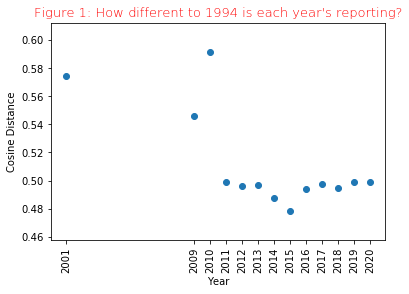

In [172]:
%matplotlib inline

#xt = period_names # we create a dummy list of each decade
#xt = xt[xt%10==0] # we use the modulus ("%") to only admit numbers "floored" to the nearest ten.
# xt will be fed to the visualization as a list of ticks for the x-axis.


plt.scatter(period_names, dists)
plt.xticks(xt)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

plt.title("Figure 1: How different to 1994 is each year's reporting?", fontsize=13, fontweight=0, color='Red')
plt.xlabel("Year")
plt.ylabel("Cosine Distance")


plt.show()

In [173]:
max(dists)

0.5914677770204784

In [174]:
min(dists)

0.47824030436236664

This is a practical measure of how much the content of EDGAR reports changed overall for the whole period, as calculated from the baseline of the first date (1994-12-31).  

We learn that the period 2011-09-24 was furthest from 1994 in terms of reports.  

We learn that 2015-12-31 was closest to 1994 in terms of its reports.


### Interpretation Trouble: What does this mean?


Good question. In text mining, no analysis of this kind is complete until we can describe what makes two periods distinct.  

Recall that the distances are calculated from word vectors, which are composed of numbers, each of which stands in for a list of words.

In [27]:
firstrow

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
secondrow

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Remember from high school math that you can subtract vectors.

In [29]:
diff = secondrow-firstrow
diff

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

What are the biggest differences between the firstrow (1994) and secondrow (2001)?  

Let's inspect "diff," the result of subtracting vectors. 

First we reformat it into a list using

        np.array -- make it a numpy dataframe
        .T -- transform 

and a for loop. 

In [30]:
# reformat the matrix as a list
diff2 = [(np.array(diff[0][0])).T]
word_count_differences_list = []
for i in range(len(diff2[0])):
        word_count_differences_list.append(list(diff2[0][i]))

Next, we call the names of all the words -- whose frequencies are represented by the numbers in the matrix.

In [31]:
all_words = np.array(vectorizer.get_feature_names())

Let's glue together all_words and word_count_differences_list:

In [32]:
words_df = pd.DataFrame(word_count_differences_list, # the matrix we saw above is turned into a dataframe
                                 columns=['distance'],
                                 index = all_words
                                 )

#### Find the biggest or smallest differences in absolute terms

We can use 

    .sort_values()


to look for the most change

In [33]:
words_df['distance'].sort_values()

raytheon      -83
page          -31
raytheons     -31
government    -29
aircraft      -27
             ... 
software      298
service       334
revenue       348
company       384
microsoft     606
Name: distance, Length: 10000, dtype: int64


The largest (positive) numbers represent the words that increased the most from 1994 to 2001:

* financial
* cash
* cost

The negative numbers represent the words that decreased the most in the same time:

* software
* cloud
* fiscal


### Comparing two periods using vectors

Above, we learned that the period 2001-06-30 -- row #1 in the matrix -- was furthest from 1994 in terms of reports.  

We learned that 2018-12-31 -- row # 24 in the matrix -- was closest to 1994 in terms of its reports (the distance was 0, which seems suspicious, so we'll use row #25 instead).

Let's compare those two periods.

In [34]:
firstrow =  matr[3,:]
firstrow

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [35]:
secondrow =  matr[8,:]
secondrow

matrix([[5, 2, 2, ..., 2, 2, 2]], dtype=int64)

Comparing them with a cosine produces one number, substantially less than other differences we've seen.

In [36]:
scipy.spatial.distance.cosine(firstrow, secondrow)

0.17350058490816433

Comparing them by subtraction produces a matrix

In [37]:
diff = secondrow-firstrow
diff

matrix([[5, 2, 2, ..., 2, 2, 2]], dtype=int64)

We can reformat that into a datatable

In [38]:
diff2 = [(np.array(diff[0][0])).T] # from matrix to array

# a loop to create a list:
word_count_differences_list = [] 
for j in range(len(diff2[0])):
    word_count_differences_list.append(list(diff2[0][j]))

# make a dataframe
words_df1 = pd.DataFrame(word_count_differences_list, # the matrix we saw above is turned into a dataframe
                                 columns=['distance'],
                                 index = all_words
                                 )

words_df1

,distance
__________,5
_______________________,2
____________________________________form,2
____________________________________indicate,2
_________________uindicates,2
...,...
zone,4
zoom,2
zpu,2
überspielungsrechte,2


We can use

        .sort_values()
    
to organize the dataframe above

In [39]:
sorted = words_df1.sort_values('distance')
sorted

,distance
reserve,-429
index,-413
corporation,-411
exxonmobil,-382
production,-381
...,...
revenue,1697
million,1750
service,1800
product,2091


### Visualize change over time

Let's collect the largest and smallest words in one dataframe for graphing.

In [40]:
growing = list(sorted.nlargest(5,'distance').index.values)
shrinking = list(sorted.nsmallest(5,'distance').index.values)
changing = growing + shrinking
changing

['company',
 'product',
 'service',
 'million',
 'revenue',
 'reserve',
 'index',
 'corporation',
 'exxonmobil',
 'production']

Let's go back to vectors_dataframe -- which has all the counts per period -- and select just those words that showed an overall increase or decrease in usage, using square brackets:

    []

In [41]:
changing_data = vectors_dataframe[changing]
changing_data

,company,product,service,million,revenue,reserve,index,corporation,exxonmobil,production
1994,34,19,14,12,0,3,0,4,0,4
2001,418,264,348,300,348,2,2,40,0,0
2009,676,150,178,770,142,496,318,656,460,548
2010,836,288,176,1592,244,1020,522,1276,688,1116
2011,3302,1961,1487,2812,1129,526,306,794,342,706
2012,3200,2074,1613,2698,1123,526,84,744,310,691
2013,3213,2018,1611,2735,1119,524,83,744,306,723
2014,3337,2013,1614,2806,1243,514,90,789,326,724
2015,3595,2379,1976,3342,1941,591,109,865,306,735
2016,3395,2290,1917,3154,1845,655,97,928,302,749


#### Graph it!

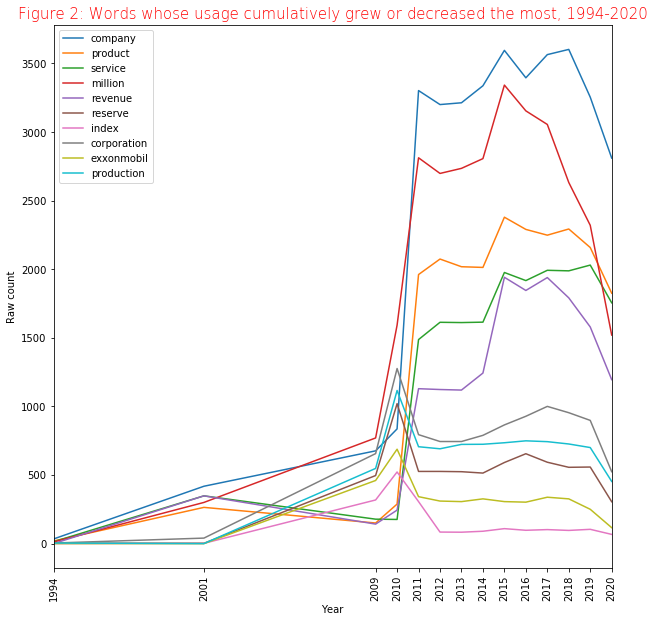

In [42]:
changing_data.plot.line(figsize=(10,10))

plt.xticks(xt)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

# Add titles
plt.title("Figure 2: Words whose usage cumulatively grew or decreased the most, 1994-2020", fontsize=15, fontweight=0, color='Red')
plt.xlabel("Year")
plt.ylabel("Raw count")

plt.show()

That's not exactly what I expected, given the sums!  Words like "Company," "tax," and "year never went away in reporting; they were important in 2001, and if anything, picked up their importance even more significantly after the financial shocks of 2011 and after 2015, even though they experienced relative declines after each of those bumps.   

We see more of what I expected in the increase in tech words -- the gradual importance of "server" and "microsoft" in reports that reference technology.  

* What's most apparent in this graph is actually not an overall increase or decrease -- but rather an up and down pattern for all the words.  Even the words that cumulatively decreased in usage actually exhibit a cyclical pattern of change -- up then down.  

* This is probably true because the quarterly reports are cyclical in nature. It looks like there's one report every year where finance is important for most companies, and another every year where tech is important.  

The difference between what we expected to see and what we actually see illustrates the importance of inspecting data multiple times -- looking at the overall sums of difference, then plotting the wordcount graphically to see what's actually going on.

* The words we collected in "biggest" and "smallest" showed the greatest absolute change from report to report.  That also means that they had some of the largest overall spikes -- they are the words that are most cyclical in nature. 

We nevertheless see some big discontinuities in the ten words in question in 2014-2016. 

* "million," "product," "expense," and "asset" spike upward dramatically.


### What if we want to measure word change across every period?

A: some for loops will help

In [43]:
matr

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 2, 2, ..., 2, 2, 2],
        [2, 0, 2, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [53]:
word_dists = pd.DataFrame()

for i in range(1,len(period_names)):  # for i representing each of the periods in question 
    
        # take the difference between two matrices

        print('calculating the difference between ', period_names[i], ' & ', period_names[i-1])
        secondrow = matr[i,:]
        firstrow = matr[i-1,:] 
        diff = (secondrow - firstrow)
        
        # reformat the difference matrix into an array, a list, and then into dataframe
        
        diff2 = [(np.array(diff[0][0])).T]
        word_count_differences_list = []
        for j in range(len(diff2[0])):
            word_count_differences_list.append(list(diff2[0][j]))
        words_df1 = pd.DataFrame(word_count_differences_list, # the matrix we saw above is turned into a dataframe
                                 columns=[period_names[i]],
                                 index = all_words
                                 )
        
        # store the results by merging them with the results from the last run through the for loop
    
        word_dists = pd.concat([word_dists, words_df1], axis=1)

calculating the difference between  2001  &  1994
calculating the difference between  2009  &  2001
calculating the difference between  2010  &  2009
calculating the difference between  2011  &  2010
calculating the difference between  2012  &  2011
calculating the difference between  2013  &  2012
calculating the difference between  2014  &  2013
calculating the difference between  2015  &  2014
calculating the difference between  2016  &  2015
calculating the difference between  2017  &  2016
calculating the difference between  2018  &  2017
calculating the difference between  2019  &  2018
calculating the difference between  2020  &  2019


Now we have a table of every word, showing the raw change in wordcount between each period and the period immediately before it. 

In [54]:
word_dists

,2001,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
__________,0,0,0,2,0,1,1,1,0,0,-2,-1,-1
_______________________,0,0,0,0,2,0,0,0,0,0,0,-2,0
____________________________________form,0,0,0,0,0,2,0,0,0,0,0,0,-1
____________________________________indicate,0,0,0,0,0,2,0,0,0,0,0,0,-1
_________________uindicates,0,0,0,0,0,0,0,2,0,0,0,0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zone,0,0,0,6,-2,0,0,0,0,0,1,0,0
zoom,0,0,0,0,0,0,2,0,0,0,0,2,0
zpu,0,0,0,0,0,2,0,0,0,0,0,-2,0
überspielungsrechte,0,0,0,0,0,2,0,0,0,0,0,-2,0


In [57]:
word_dists['2']

KeyError: '2'

### Comparing the words used in any two periods

We can call up the words whose counts were changing the most and the least for every period in question

Remember that 2011-9-24 was the most distant from 1994. What changed?

In [52]:
word_dists['2001'].sort_values()

KeyError: '2001'

In 2011, people were writing about software, not about oil, for starters.  If I were writing an answer to an essay question, I could look at the results more carefully and talk in greater detail.

Recall that 2015-12-31 was the *closest* to 1994 in terms of language.  What was that like?

In [49]:
word_dists['2019'].sort_values()

KeyError: '2019'

In both 1994 and 2004, people were talking about apple, sales, and companies.  

### Comparing the words that changed the most over all periods

We can also look for the individual words whose usage grew or shrunk the most in aggregate over time.

In [46]:
word_dists["sum"] = word_dists.sum(axis=1)
word_dists["sum"].sort_values()

raytheon      -83
president     -33
raytheons     -31
aircraft      -29
page          -27
             ... 
september     346
note          369
financial     394
product       411
company      1726
Name: sum, Length: 10000, dtype: int64

Surprise! We've seen them before. That's because the sum of every row is the same as the total change in raw word counts for every word, which we measured up above.

## Assignment

Your assignment includes a coding exercise and a brainstorming exercise.

#### Coding Exercise

We're going to ask you to do a coding exercise that builds upon your skills from earlier weeks and uses the code from this week.

* Return to the dataset at the beginning of this notebook. Recall how in Week 5 we used the datetime package to extract the year from dates, to generalize the decade from the year, and to group_by year and date.  Call the EDGAR dataset, but group_by decade or year instead of period.
* We'll ask you to recreate the measurements of this dataset using data grouped by decade or year:
    * Run Figure 1 again, but this time, calculated by the largest and smallest differences over years or decades rather than over periods. Remember that you will need to "group by" year or decade before creating the word bectors and measuring the difference between word vectors.  Give it an appropriate label. 
    * Use subtracting vectors to find out the words that are the most or least different between the two periods. 
    * Recreate Figure 2 with those words. Give it an appropriate label. 
* Write a paragraph of analysis about the new words. Label this, "Analysis of relative distance of Years/Decades from 1994"
* Write a paragraph comparing your findings with the words in the original Figure 2.  Label this, "Analysis of words changing between [first period] and [second period]"

#### Brainstorming Exercise

We'll also ask you to perform a brainstorming exercise about how this code might apply to your dataset.

* To apply distance measures to your own work, you will have to first group the data into several categories, using the instructions in the “pandas” notebook and previous notebooks using the “groupby” command.  For instance, if you’re measuring novels, you could inspect the difference between the five most productive novelists as measured by the number of novels each wrote.  Or if you were measuring parliament, you could ask about the difference between Conservative party speakers and Liberal party speakers.  What would you “groupby” to better understand your data? 
*Something to keep in mind: Unlike with distinctiveness measures -- where having too many entities measured against each other will produce nonsense -- distance measures are completely fine to use with many, many entries.  You can measure 100 novelists against each other and find out which were the most similar. You can measure a million novels and figure out which novels share the most similar vocabulary with Oliver Twist.  How can you use the features of distance measures to enhance your work?*

    * Propose three existing fields that you could "groupby" to measure distance. 
    * Write a sentence for each telling us about why this research would potentially be meaningful. 
    
* Sometimes you need to create a new field to get the desired results. For instance, we created the “decade” and “year” fields by using the datetime package, having only previously had precise temporal measurements. Distance measures are routinely used to understand how the context of a word is changing -- see, for example, Lauren Klein's article about how conversations about "justice" changed with the movement for the abolition of slavery in America.  
    * How would you structure the data to measure how the context of every word in EDGAR was changing?
    * How would you structure the data to understand how words were changing their context in your data?
    * Write a sentence for each telling us what insight this would potentially give you about your data.

#### Please submit to Canvas: 
* two visualizations (the new Figure 1 and Figure 2), 
* two paragraphs of data analysis, and 
* eight bullet-pointed proposals for how you might apply distinctiveness measures to your dataset, with at least one sentence of explanation each.

Please format these as a .pdf or .doc. Do not turn in a full ipynb.